In [333]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.stats as scst

In [459]:
sim = 'TNG300-1'
pos = np.loadtxt('../data/summary_pos_{}.dat'.format(sim))
pec_vel = np.loadtxt('../data/summary_vcm_{}.dat'.format(sim))
vel = np.loadtxt('../data/summary_vel_{}.dat'.format(sim))
mass = np.loadtxt('../data/summary_mass_{}.dat'.format(sim))
print(len(mass))

d = np.sqrt((pos[:,3]-pos[:,0])**2 + (pos[:,4]-pos[:,1])**2 + (pos[:,5]-pos[:,2])**2)
ii = d < 2000
d = d[ii]

pec_vel = pec_vel[ii]
vel = vel[ii]
pos = pos[ii]
mass = mass[ii]

ii = mass[:,0]>mass[:,1]
tmp_vel = vel[ii,0:3].copy()
vel[ii,0:3] = vel[ii,3:6].copy()
vel[ii,3:6] = tmp_vel[:,0:3].copy()

tmp_pos = pos[ii,0:3].copy()
pos[ii,0:3] = pos[ii,3:6]
pos[ii,3:6] = tmp_pos[:,0:3]

tmp_mass = mass[ii,0]
mass[ii,0] = mass[ii,1].copy()
mass[ii,1] = tmp_mass[:]

total_mass = mass[:,0]+ mass[:,1]
mass_ratio = mass[:,0]/mass[:,1]


delta_v = np.zeros([len(d),3])
for i in range(3):
    delta_v[:,i] = vel[:,i+3] - vel[:,i]

delta_r = np.zeros([len(d),3])
for i in range(3):
    delta_r[:,i] = pos[:,i+3] - pos[:,i]

cm_vel = np.zeros([len(d),3])
for i in range(3):
    cm_vel[:,i] = (mass[:,0]*vel[:,i] + mass[:,1]*vel[:,i+3])/(total_mass)
    
norm_cm_vel = np.sqrt(np.sum(cm_vel**2, axis=1))
    
cm_vel_hat = cm_vel.copy()
for i in range(3):
    cm_vel_hat[:,i] = cm_vel_hat[:,i]/norm_cm_vel
    
r_hat = delta_r.copy()
norm_delta_r = np.sqrt(np.sum(delta_r*delta_r, axis=1))
for i in range(3):
    r_hat[:,i] = delta_r[:,i]/norm_delta_r


v_hat = delta_v.copy()
norm_delta_v = np.sqrt(np.sum(delta_v*delta_v, axis=1))
for i in range(3):
    v_hat[:,i] = delta_v[:,i]/norm_delta_v

mu_vr = np.zeros(len(v_hat))
for i in range(3):
    mu_vr += v_hat[:,i] * r_hat[:,i]
    
mu_vcmr = np.zeros(len(cm_vel_hat))
for i in range(3):
    mu_vcmr += cm_vel_hat[:,i] * r_hat[:,i]
    
for i in range(3):
    v_rad[:,i] = delta_v[:,i]*r_hat[:,i]

norm_v_rad = np.zeros(len(d))
for i in range(3):
    norm_v_rad[:] += delta_v[:,i]*r_hat[:,i]

v_rad = np.zeros([len(d),3])
for i in range(3):
    v_rad[:,i] = norm_v_rad[:] * r_hat[:,i]
    
    
v_tan = np.zeros([len(d),3])
for i in range(3):
    v_tan[:,i] = delta_v[:,i] - v_rad[:,i]
norm_v_tan = np.sqrt(np.sum(v_tan*v_tan, axis=1))

# this includes now hubble flow
delta_v_hflow = delta_v.copy()
for i in range(3):
    delta_v_hflow[:,i] = delta_v[:,i] + 0.1*delta_r[:,i]

norm_delta_v_hflow = np.zeros(len(d))
for i in range(3):
    norm_delta_v_hflow[:] += delta_v_hflow[:,i]*r_hat[:,i]

5385


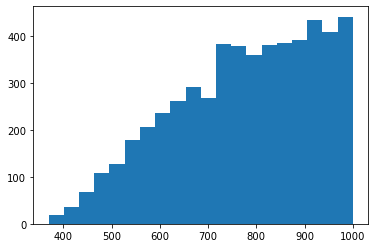

In [460]:
_ = plt.hist(norm_delta_r, bins=20)

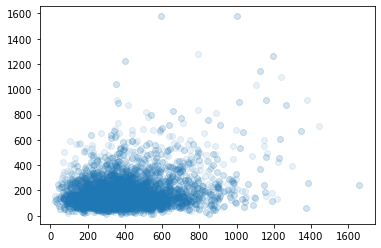

In [461]:
plt.scatter(pec_vel, norm_delta_v, alpha=0.1)

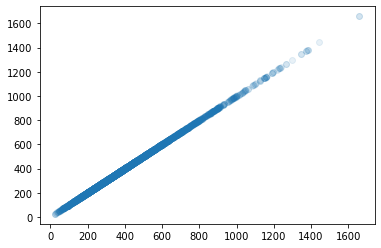

In [462]:
plt.scatter(pec_vel, norm_cm_vel, alpha=0.1)

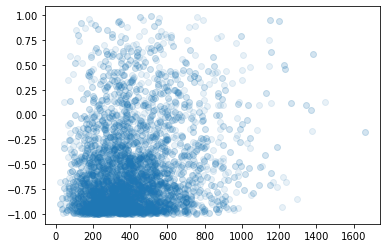

In [463]:
plt.scatter(norm_cm_vel, mu_vr, alpha=0.1)

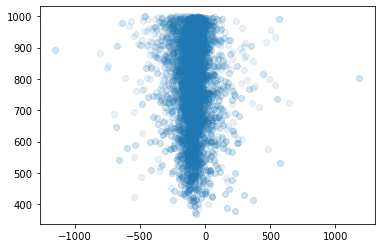

In [464]:
plt.scatter(norm_v_rad, norm_delta_r, alpha=0.1)

In [465]:
ii = norm_v_rad<0
print(np.count_nonzero(ii)/len(ii))

0.8823968639163711


In [466]:
def compare(pec_vel, probe, name='probe', xlim=[0,100]):
    nn = len(probe)
    isort = np.argsort(pec_vel)
    ii_4 = isort[-nn//4:]
    plt.plot(np.sort(probe), np.linspace(0.0, 1.0, nn))
    plt.plot(np.sort(probe[ii_4]), np.linspace(0.0, 1.0, np.count_nonzero(ii_4)))
    res = scst.ks_2samp(probe,probe[ii_4])
    print(res.statistic)
    print(res.pvalue)
    plt.title('KS statistic={:.2f} - p_value={:.2e}'.format(res.statistic, res.pvalue))
    plt.xlabel(name)
    plt.xlim(xlim)
    plt.grid()

0.030849021645552338
0.2532284766912162


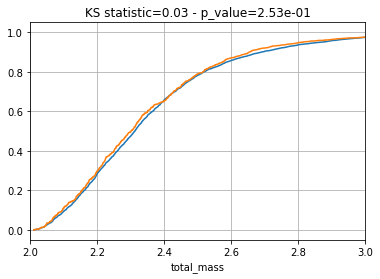

In [467]:
compare(pec_vel, np.log10(total_mass), name='total_mass', xlim=[2,3])

0.026353578383980787
0.43730605969402203


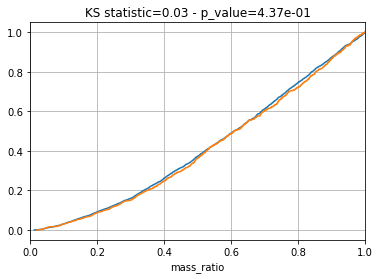

In [468]:
compare(pec_vel, mass_ratio, name='mass_ratio', xlim=[0,1])

0.10949963640821467
1.1805556532351602e-11


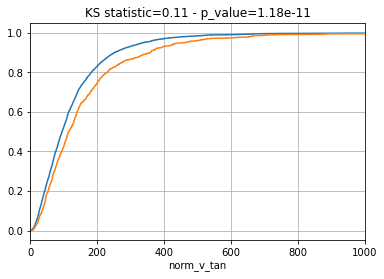

In [469]:
compare(pec_vel, norm_v_tan, name='norm_v_tan', xlim=[0,1000])

0.1081189627743307
2.302658064223806e-11


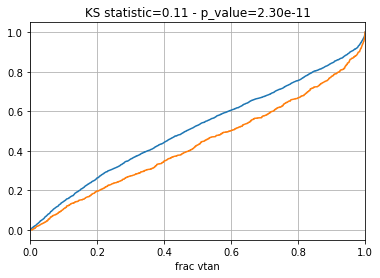

In [470]:
#beta = 1 - 0.5*(norm_v_tan**2/norm_v_rad**2)
compare(pec_vel, norm_v_tan**2/norm_delta_v**2, name='frac vtan', xlim=[0,1])

0.1081189627743307
2.302658064223806e-11


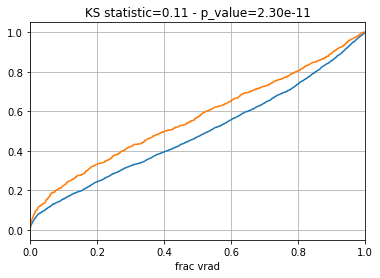

In [471]:
compare(pec_vel, norm_v_rad**2/norm_delta_v**2, name='frac vrad', xlim=[0,1])

0.08451091168314506
2.4919686842928e-06


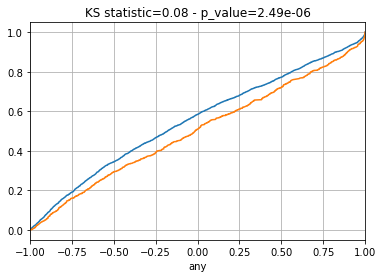

In [479]:
lll = norm_v_rad<0
compare(pec_vel[lll], ((norm_v_tan[lll]**2 - norm_v_rad[lll]**2)/norm_delta_v[lll]**2), name='any', xlim=[-1,1])

0.09872324953541049
1.510402358739782e-09


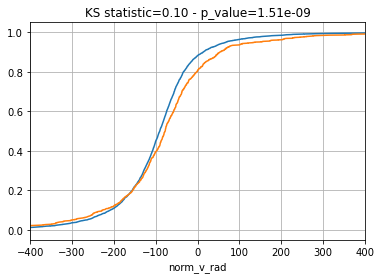

In [473]:
compare(pec_vel, norm_v_rad, name='norm_v_rad', xlim=[-400.0, 400])

0.08533513132489504
3.0631342562426056e-07


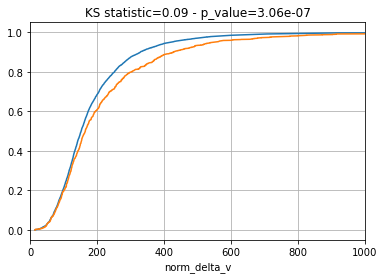

In [455]:
compare(pec_vel, norm_delta_v, name='norm_delta_v', xlim=[0,1000])

0.11725793284835855
2.73225886360251e-13


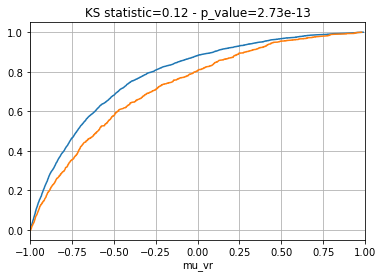

In [475]:
compare(pec_vel, mu_vr, name='mu_vr', xlim=[-1,1])

0.027736620240221332
0.3734377961776303


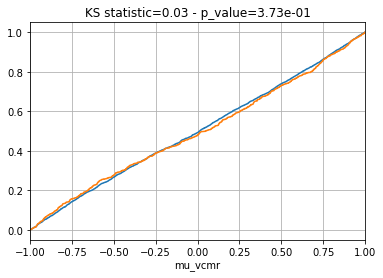

In [458]:
compare(pec_vel, mu_vcmr, name='mu_vcmr', xlim=[-1,1])

0.02524970815142135
0.49216846822128246


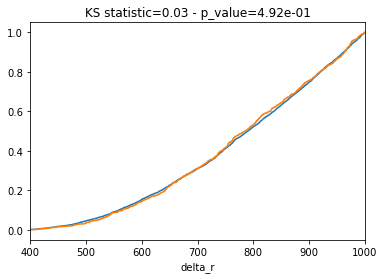

In [420]:
compare(pec_vel, norm_delta_r, name='delta_r', xlim=[400,1000])

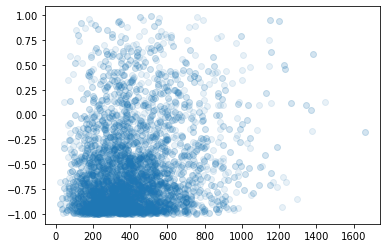

In [421]:
plt.scatter(pec_vel, mu_vr, alpha=0.1)